# 三. 线性模型

线性回归输出是一个连续值，因此适用于回归问题。回归问题在实际中很常见，如预测房屋价格、气温、销售额等连续值的问题。与回归问题不同，分类问题中模型的最终输出是一个离散值。我们所说的图像分类、垃圾邮件识别、疾病检测等输出为离散值的问题都属于分类问题的范畴。Logit和softmax回归则适用于分类问题。

由于线性回归和softmax回归都是单层神经网络，它们涉及的概念和技术同样适用于大多数的深度学习模型。我们首先以线性回归为例，介绍大多数深度学习模型的基本要素和表示方法。

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.linear_model import LinearRegression
from IPython import display
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

## 1. 基本形式
给定由d个属性描述的示例$\mathbf{x}=(x_1;x_2;...;x_d)$，其中$x_i$是$x$在第i个属性上的取值，线性模型试图学得通过属性的线性组合来进行预测的函数，即
$$f(\mathbf{x})=\omega_1x_1 + \omega_2x_2+...+\omega_dx_d+b,$$
一般用向量形式写出
$$f(\mathbf{x})=\mathbf{x\omega}+b,$$
其中$\mathbf{\omega}=(\omega_1;\omega_2;...;\omega_d)$. $\mathbf{\omega}$和b学得后，模型就确定了.

## 2. 线性回归
给定数据集$D=\{(\mathbf{x_1},y_1),(\mathbf{x_2},y_2),...,(\mathbf{x_m},y_m)\}$，其中$\mathbf{x_i}=(x_{i1};x_{i2};...;x_{id}),y_i\in R$. 线性回归试图学得一个线性模型以尽可能准确地预测实数值输出标记. 我们试图学得
$$f(\mathbf{x_i})=\mathbf{x_i}+b,使得f(x_i)\simeq y_i,$$
这称为“多元线性回归”(multivariate linear regression).
可以利用**最小二乘法**对$\mathbf{\omega}$和b进行估计。假定$\mathbf{\hat \omega}=(\mathbf{\omega};b)$，相应地
$$
\mathbf{X} =
\begin{pmatrix}
    x_{11} & x_{12} & ... & x_{1d} & 1 \\
    x_{21} & x_{22} & ... & x_{2d} & 1 \\
    ... \\
    x_{m1} & x_{m2} & ... & x_{md} & 1
\end{pmatrix} = 
\begin{pmatrix}
    \mathbf{x_1^T} & 1 \\
    \mathbf{x_2^T} & 1 \\
    ... \\
    \mathbf{x_m^T} & 1
\end{pmatrix}, \mathbf{y}=
\begin{pmatrix}
y_1 \\
y_2 \\
... \\
y_m
\end{pmatrix}=(y_1;y_2;...;y_m)
$$

In [11]:
def linearModel(X: torch.tensor, w: torch.tensor)-> torch.tensor:
    """
    X: N*a, N为样本数量，a为（增广）特征维度
    w: a*1
    """
    return X@w.reshape(-1, 1)

In [14]:
def synthetic_data(w, num_examples):
    """Generate y = Xw + noise."""
    X = torch.normal(0, 1, (num_examples, len(w) - 1))
    hat_X = torch.cat([X, torch.ones(num_examples, 1)], 1)
    y = linearModel(hat_X, w)
    y += torch.normal(0, 0.01, y.shape)
    return hat_X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4, 1])  # 增广参数（包含截距项）
features, labels = synthetic_data(true_w, 1000)

如何确定$\mathbf{\hat\omega}$呢？关键在于衡量$f(\mathbf{x})$和$y$的差别。均方误是回归任务中最常用的性能衡量指标，因此我们可以试图让均方误差最小化.
$$
\mathbf{\hat\omega^*}=\operatorname*{argmin}_{\mathbf{\hat\omega}}\mathbf{\frac{1}{2m}(y-X\hat\omega)^T(y-X\hat\omega)}.
$$
其中m为样本数量。令$E_{\mathbf{\hat\omega}}=\mathbf{\frac{1}{2m}(y-X\hat\omega)^T(y-X\hat\omega)}$，对$\mathbf{\hat\omega}$求导可得
$$
\cfrac{\partial E_{\hat{w}}}{\partial \hat{w}}=\frac{1}{m}\mathbf{X}^T(\mathbf{X}\hat{w}-\mathbf{y}).
$$
令上式为0可得$\mathbf{\hat\omega}$最优解的封闭解。

>**最大似然估计角度**
>
> 假定残差服从正态分布，$\epsilon\sim N(0,\sigma^2)$，即有$(y-xw^T)\sim N(0,\sigma^2)$。
>
> 根据最大似然估计原则，建立优化目标
> $$
\max \prod_{i=0}^N \frac{1}{\sqrt{2\pi}\sigma}\exp\left({-\frac{(y_i-x_i\hat{w}^T)^2}{2\sigma^2}}\right)
> $$
> 化简后可
> $$
\max \frac{1}{(\sqrt{2\pi}\sigma)^N}\exp{\left(-\frac{\sum_{i=1}^N(y_i-x_i\hat{w}^T)^2}{2\sigma^2}\right)}
> $$

> 等价于最小二乘优化目标
>$$
\min \mathbf{(y-X\hat{w})(y-X\hat{w})^T}
$$

In [13]:
def meanSquaredLoss(X: torch.tensor, y: torch.tensor, w: torch.tensor) -> torch.tensor:
    """
    X: N*a, N为样本数量，a为（增广）特征维度
    y: N, 标签
    w: a*1
    """
    hat_y = X @ w.reshape(-1, 1)
    sLoss = torch.dot(hat_y.reshape(-1) - y.reshape(-1), hat_y.reshape(-1) - y.reshape(-1))
    return sLoss / y.numel()

In [21]:
w = torch.tensor([2, -3.4, 1])
meanSquaredLoss(features, labels, w)

tensor(9.9284e-05)

**正则化：在实际回归任务中，往往会遇到大量特征的数据集。为了防止过拟合，以上损失函数也可以加入对参数的惩罚，常用的有L1和L2惩罚。**
- `L1: Lasso regression`
$$
\min \frac{1}{2}(y-X\hat{w})(y-X\hat{w})^T+\frac{1}{2}\lambda \sum_{i=1}^d|w_i|
$$

等价于

$$
\min \frac{1}{2}(y-X\hat{w})(y-X\hat{w})^T \\
\text{s.t.  } \sum_{i=1}^d|w_i|\leq t 
$$

- `L2: Ridge resgression`
$$
\min \frac{1}{2}(y-X\hat{w})(y-X\hat{w})^T+\frac{1}{2}\lambda ww^T
$$

等价于

$$
\min \frac{1}{2}(y-X\hat{w})(y-X\hat{w})^T \\
\text{s.t.  } ww^T \leq t 
$$


In [23]:
def meanSquaredLoss_Penalty(X, y, w, delta=0.5, l=2):
    """
    X: N*a, N为样本数量，a为（增广）特征维度
    y: N, 标签
    w: a*1
    delta: 惩罚系数, 超参数
    l: 取0, 1, 2, 分别表示不惩罚，l1惩罚和l2惩罚
    """
    hat_y = X @ w.reshape(-1, 1)
    sLoss = torch.dot(hat_y.reshape(-1) - y.reshape(-1), hat_y.reshape(-1) - y.reshape(-1))
    if l == 0:
        penalty = 0
    elif l == 1:
        penalty = torch.sum(torch.abs(w.reshape(-1)[:-1]))
    else:
        penalty = torch.sqrt(torch.dot(w.reshape(-1)[:-1], w.reshape(-1)[:-1]))
    return (sLoss + delta*penalty) / y.numel()

In [24]:
meanSquaredLoss_Penalty(features, labels, w, delta=1, l=2)

tensor(0.0040)

当$\mathbf{X^t X}$为满秩矩阵或正定矩阵时，令$\cfrac{\partial E_{\hat{w}}}{\partial \hat{w}}=0$可得
$$
\mathbf{\hat\omega^*=(X^TX)^{-1}X^Ty},
$$
其中$\mathbf{(X^TX)^{-1}}$是$(X^TX)$的逆矩阵. 令$\mathbf{\hat x_i} = (\mathbf{x_i}; 1)$，则最终学得的线性回归模型为
$$
f(\mathrm{\hat x_i})=\mathbf{\hat x_i^T(X^TX)^{-1}X^Ty}.
$$

然而，现实任务中$\mathbf{X^t X}$往往不是满秩矩阵，而且随着数据量的增加，计算量呈现大幅增长。因此，往往求助于数值优化算法迭代求解。

In [25]:
def grad_mse_w(X, y, w):
    '''
    X: N*a, N为样本数量，a为（增广）特征维度
    y: N
    w: a*1
    '''
    return 2*(X.t()@(X@w.reshape(-1, 1) - y.reshape(-1, 1))) / y.numel()

In [26]:
grad_mse_w(features, labels, w)

tensor([[-2.2020e-04],
        [ 8.5193e-04],
        [-9.2972e-05]])

- 评价指标
    - 回归平方和：$\mathrm{SS_{res}}=\sum_{i=1}^{n}(y_i - f(x_i))^2$
    - 总平方和：$\mathrm{SS_{tot}=\sum_{i=1}^n(y_i-\bar{y})^2}$
    - 决定系数：$R^2 = \mathrm{\frac{SS_{tot}-SS_{res}}{SS_{tot}}}$

## 3. 利用`sciki-learn`实现线性回归模型
可以使用`scikit-learn`的`LinearRegression`模块实现线性回归模型，其中有两个关键属性，`fit_intercept`指定是否保留截距，`normalize`指定是否使用标准化数据进行模型拟合。

- 根据披萨的尺寸预测价格

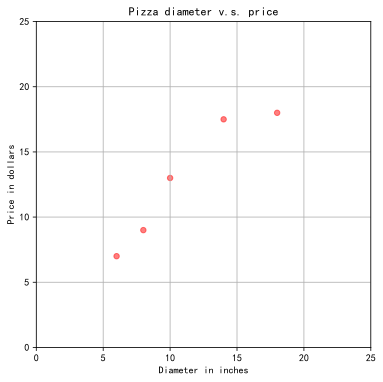

In [27]:
X = np.array([[6], [8], [10], [14], [18]]) # X为训练数据的特征，即直径
y = np.array([7, 9, 13, 17.5, 18])  # 披萨价格

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Pizza diameter v.s. price")
ax.set_xlabel("Diameter in inches")
ax.set_ylabel("Price in dollars")
ax.scatter(X, y, s=30, alpha=0.5, c="red")
ax.axis([0, 25, 0, 25])
ax.grid(True)

- 拟合

In [28]:
model = LinearRegression(fit_intercept=True, normalize=True)  # 创建一个scikit-learn估计器实例

In [29]:
model.fit(X, y)  # 利用数据拟合模型
model.get_params()  # 模型设置的参数

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': True,
 'positive': False}

In [30]:
print(f"拟合参数估计值: {model.coef_}\n截距项值:{model.intercept_}")
r2 = model.score(X, y)  # 模型的r2
print(f"R2: {r2: .4f}")

拟合参数估计值: [0.9762931]
截距项值:1.965517241379315
R2:  0.9100


- 预测值

In [31]:
test_pizza = np.array([[12], [18], [20], [21]])
predicted_price = model.predict(test_pizza)

In [32]:
predicted_price

array([13.68103448, 19.5387931 , 21.49137931, 22.46767241])

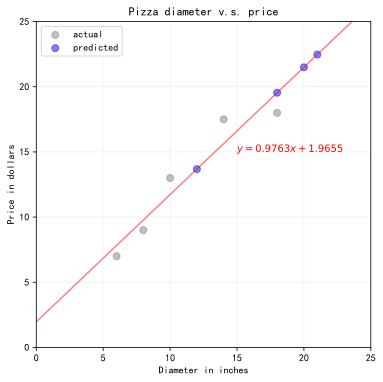

In [33]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Pizza diameter v.s. price")
ax.set_xlabel("Diameter in inches")
ax.set_ylabel("Price in dollars")
ax.plot(np.linspace(0, 25, num=100), model.predict(np.linspace(0, 25, num=100).reshape(-1, 1)), 
        'r-', alpha=0.5)
ax.scatter(X, y, s=50, alpha=0.5, c="grey", label="actual")
ax.scatter(test_pizza, predicted_price, s=50, alpha=0.5, c="blue", label="predicted")
ax.axis([0, 25, 0, 25])
ax.text(15, 15, '$y=0.9763x+1.9655$', color='red')
ax.legend()
ax.grid(True, alpha=0.2)
plt.savefig("../pictures/4.1.svg")

In [34]:
mse = np.mean((model.predict(X) - y)**2)
print(f"Residual of MSE: {mse:.2f}")

Residual of MSE: 1.75


## 4. 基于梯度下降实现多元线性回归

- 生成模拟数据

In [35]:
def synthetic_data(w, N, bias=True):
    '''
    y = Xw + noise
    w: a*1, (增广)权重
    N: 样本数量
    bias: w中是否包含偏置
    '''
    if bias:
        X = torch.cat([torch.randn(N, w.numel()-1), torch.ones(N, 1)], axis=1)
    else:
        X = torch.randn(N, w.numel())

    y = (X @ w.reshape(-1, 1)).reshape(-1, 1)  # torch.matmul(X, w).reshape(-1, 1)
    y += torch.randn(size=y.size()) * 0.01
    return X, y

In [36]:
true_w = torch.Tensor([2, -3.4, 4.2])  # 特征权重为2, -3.4, 偏置权重为4.2
features, labels = synthetic_data(true_w, 1000)

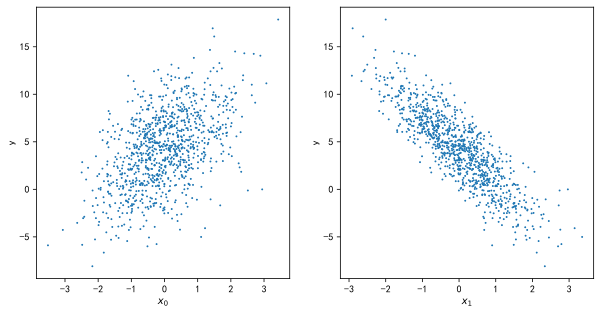

In [37]:
fig = plt.figure(figsize=(10,5))
# y随第1个特征x_0的散点图
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("$x_0$")
ax1.set_ylabel("y")
ax1.scatter(features[:, 0].numpy(), labels.numpy(), s=1)
# y随第2个特征x_1的散点图
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("y")
ax2.scatter(features[:, 1].numpy(), labels.numpy(), s=1);

In [38]:
meanSquaredLoss(features, labels, true_w)

tensor(9.4031e-05)

**线性回归的梯度下降参数学习算法**
- 输入: 特征`X`, 标签`y`, 样本数量`m`, 训练回合数`epochs`, 学习率$\eta$
- 输出: 最优参数$w^*$，训练模型$f(x, w^*)$
- 算法过程:
    - 初始化参数值w, 当前回合数`epoch=1`
    - 如果`epoch > n`, 转至下一步, 否则执行以下循环
        - 更新参数值$w := w - \frac{\eta}{m}\mathbf{X}^T(\mathbf{X}\hat{w}-\mathbf{y})$
        - 更新训练次数`epoch := epoch + 1`
    - 令$w^*=w, f(x, w^*)=x^Tw^*$, 算法结束

In [39]:
def lm_grad_desc(features, labels, epochs=100, learn_rate=0.05):
    w = torch.randn(features.shape[1], 1)
    for epoch in range(epochs):
        w -= learn_rate * grad_mse_w(features, labels, w)
        if (epoch + 1) % 10 == 0:
            mse = meanSquaredLoss(features, labels, w)
            print(f"{epoch + 1}: {mse:.4f}")

    return w

In [40]:
w = lm_grad_desc(features, labels)
print(w)

10: 6.0627
20: 0.7221
30: 0.0861
40: 0.0103
50: 0.0013
60: 0.0002
70: 0.0001
80: 0.0001
90: 0.0001
100: 0.0001
tensor([[ 2.0000],
        [-3.3994],
        [ 4.1998]])


- 基于`torch`自动求导

In [41]:
def lm_gd_auto(features, labels, epochs=100, learn_rate=0.05):
    w = torch.randn(features.shape[1], 1)
    w.requires_grad_(True)
    # w = torch.randn(size=(num_inputs, 1), requires_grad=True)
    for epoch in range(epochs):
        loss = meanSquaredLoss(features, labels, w)
        # 计算损失函数在 w 上的梯度
        loss.backward()
        # 原地操作，结果等价于 param -= lr * param.grad
        w.data.sub_(learn_rate * w.grad.data)
        # 需将梯度重置为0，否则会被累加，影响迭代结果
        w.grad.data.zero_() 
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():  # 不计算梯度，加速损失函数的运算
                # 最近一次的损失函数值
                train_l = meanSquaredLoss(features, labels, w)  
                # detach得到一个有着和原tensor相同数据的tensor
                est_w = w.detach().data.reshape(-1).numpy()
                print(f'epoch {epoch + 1}, mean of squared loss: {train_l.numpy():.4f}')

    return w.detach().data

In [42]:
lm_gd_auto(features, labels)

epoch 10, mean of squared loss: 3.1340
epoch 20, mean of squared loss: 0.3772
epoch 30, mean of squared loss: 0.0455
epoch 40, mean of squared loss: 0.0056
epoch 50, mean of squared loss: 0.0008
epoch 60, mean of squared loss: 0.0002
epoch 70, mean of squared loss: 0.0001
epoch 80, mean of squared loss: 0.0001
epoch 90, mean of squared loss: 0.0001
epoch 100, mean of squared loss: 0.0001


tensor([[ 2.0000],
        [-3.3995],
        [ 4.1998]])

## 5. 基于小批量随机梯度下降实现多元线性回归

在求数值解的优化算法中，小批量随机梯度下降(`mini-batch stochastic gradient descent`)在深度学习中被广泛使用。

**线性回归的小批量随机梯度下降学习方法**
- 输入: 特征`X`, 标签`y`, 批次样本量`batch_size`, 训练回合总数`epochs`, 学习率$\eta$
- 输出: 最优参数$w^*$，训练模型$f(x, w^*)$
- 算法过程:
    - 初始化模型参数值`w`，如随机选取，初始化当前回合数`epoch=1`;
    - 构建小样本生成器: 随机打乱样本次序，然后依次取出`batch_size`的样本作为用于一次参数更新的样本
    - 如果`epoch > epochs`，则跳至下一步，否则进行以下循环
        - 由小样本生成器依次取出`batch_size`的小样本$\{X_s, y_s\}$，按照$w:=w-\frac{1}{\mathrm{batch\_size}}\eta \mathbf{X_s}^T(\mathbf{X_s}\hat{w}-\mathbf{y_s})$，直到取完，
        - 则更新`epoch:= epoch+1`；
    - 令$w^*=w, f(x, w^*)=x^Tw^*$, 算法结束

> - 每一次小批量更新为一次迭代，所有训练集的样本更新一遍为一个回合
> - **批量梯度下降法**和**随机梯度下降**可以看作是**小批量随机梯度下降法**的特殊形式，批量梯度下降法使用所有的样本更新参数，随机梯度下降使用1个样本更新参数，小批量随机梯度下降法选择1个小样本更新参数

In [43]:
# 随机选取batch_size数量的数据，生成器
def sampleData(batch_size, features, labels):
    """
    随机打乱样本次序，然后依次取出batch_size的(features, labels)作为训练集
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机打乱索引次序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[j], labels[j]  # 没调用一次函数，生成一个批次样本

- 方法1: 自己写导数

In [45]:
def lm_mb_grad_desc(features, labels, batch_size=20, epochs=100, learn_rate=0.05):
    w = torch.randn(features.shape[1], 1)
    for epoch in range(epochs):
        for X, y in sampleData(batch_size, features, labels):
            w -= learn_rate * grad_mse_w(X, y, w)

        if (epoch + 1) % 2 == 0:
            mse = meanSquaredLoss(features, labels, w)
            print(f"{epoch + 1}: {mse:.4f}")
    return w

In [46]:
w = lm_mb_grad_desc(features, labels, epochs=10)
w

2: 0.0001
4: 0.0001
6: 0.0001
8: 0.0001
10: 0.0001


tensor([[ 1.9987],
        [-3.3995],
        [ 4.2000]])

> 当`batch_size=1`时，即为随机梯度下降

In [48]:
# 初始化参数
num_inputs= 3
w = torch.randn(num_inputs, 1) * 0.1
lr = 0.05  # Learning rate
num_epochs = 10  # 一共训练次数
batch_size = 1  # 一批包含的样本数量

for epoch in range(num_epochs):
    for X, y in sampleData(batch_size, features, labels):
        w -= lr * grad_mse_w(X, y, w) / batch_size
    
    if (epoch + 1) % 2 == 0:
        mse = meanSquaredLoss(features, labels, w)
        print(f"{epoch + 1}: {mse:.4f}")

print(w)

2: 0.0001
4: 0.0001
6: 0.0002
8: 0.0001
10: 0.0001
tensor([[ 1.9978],
        [-3.3960],
        [ 4.1995]])


- 方法2: 利用`torch`的`auto_grad`求导

In [49]:
def lm_mbgd_auto(features, labels, batch_size=20, epochs=10, learn_rate=0.05):
    w = torch.randn(features.shape[1], 1)
    w.requires_grad_(True)
    # w = torch.randn(size=(num_inputs, 1), requires_grad=True)
    for epoch in range(epochs):
        for X, y in sampleData(batch_size, features, labels):
            loss = meanSquaredLoss(X, y, w)
            # 计算损失函数在 w 上的梯度
            loss.backward()
            # 原地操作，结果等价于 param -= lr * param.grad
            w.data.sub_(learn_rate * w.grad.data)
            # 需将梯度重置为0，否则会被累加，影响迭代结果
            w.grad.data.zero_() 

        if (epoch + 1) % 10 == 0:
            with torch.no_grad():  # 不计算梯度，加速损失函数的运算
                # 最近一次的损失函数值
                train_l = meanSquaredLoss(features, labels, w)  
                # detach得到一个有着和原tensor相同数据的tensor
                est_w = w.detach().data.reshape(-1).numpy()
                print(f'epoch {epoch + 1}, mean of squared loss: {train_l.numpy():.4f}')

    return w.detach().data

In [50]:
lm_mbgd_auto(features, labels)

epoch 10, mean of squared loss: 0.0001


tensor([[ 2.0008],
        [-3.3987],
        [ 4.1996]])

## 6. 利用`torch.nn.Module`实现

### 6.1 准备数据

In [51]:
from torch.utils.data import TensorDataset, DataLoader

利用`TensorDataset`和`DataLoader`构建小批量数据加载器， 等价于`sampleData`过程

In [52]:
batch_size = 10  # 构建10个批次的训练集
p_features = features[:, :-1]
dataset = TensorDataset(p_features, labels)
data_iter = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

### 6.2 创建模型

```python
class LinearModel(torch.nn.Module):
    def __init__(self, ndim):
        super(LinearModel, self).__init__()
        self.ndim = ndim
        self.w = torch.nn.Parameter(torch.randn(self.ndim, 1))  # params
        self.b = torch.nn.Parameter(torch.tensor(0, dtype=torch.float16))  # bias

    def forward(self, X):
        return X@self.w + self.b
```

In [53]:
class LinearRegressionModel(torch.nn.Module): 
    def __init__(self, num_input, num_output):
        # 首先找到LinearModel的父类torch.nn.Module，然后把类LinearModel的对象转换为类torch.nn.Module的对象, 
        # 即执行父类torch.nn.Module的初始化__init__()
        super(LinearRegressionModel, self).__init__() 
        self.layer1 = torch.nn.Linear(num_input, num_output, bias=True)
        
    def forward(self, x):
        y_pred = self.layer1(x)
        return y_pred

In [54]:
# 初始化实例，2维特征，1维输出
num_input, num_output = 2, 1
net = LinearRegressionModel(num_input, num_output)
# 初始化权重和偏差
net.layer1.weight.data = torch.randn(num_output, num_input)
net.layer1.bias.data = torch.randn(1)
# 定义损失函数
# reduction指定了应用于output的方法：'none' | 'mean' | 'sum'
loss = torch.nn.MSELoss(reduction = "sum") 
# 定义训练方法
trainer = torch.optim.SGD(net.parameters(), lr=0.05)  # 随机梯度下降算法

In [55]:
# 训练
num_epochs = 10
for epoch in range(num_epochs): 
    for X, y in data_iter:
        l = loss(net.forward(X), y)  # 计算损失函数值
        trainer.zero_grad()  # 参数梯度归0
        l.backward()  # 计算参数梯度
        trainer.step()  # 执行一步随机梯度下降算法
    
    with torch.no_grad():  # 不计算梯度，加速损失函数的运算
        l_epoch = loss(net(p_features), labels) 
        print('epoch {}, loss {}'.format(epoch+1, l_epoch)) 

epoch 1, loss 0.13451094925403595
epoch 2, loss 0.12094207108020782
epoch 3, loss 0.13848647475242615
epoch 4, loss 0.1077929139137268
epoch 5, loss 0.14652128517627716
epoch 6, loss 0.1092672348022461
epoch 7, loss 0.11931698024272919
epoch 8, loss 0.13045862317085266
epoch 9, loss 0.09780678153038025
epoch 10, loss 0.1427452266216278


In [56]:
w = list(net.parameters())[0][0]
print('estimates of w:', w.detach().data)
b = list(net.parameters())[1][0]
print('estimate of b:', b.detach().data)

estimates of w: tensor([ 2.0037, -3.4007])
estimate of b: tensor(4.2058)


## 练习
1. 请基于`torch`实现多项式回归。
$$
y=\alpha + \sum_{i=1}^pX^iw_i
$$

2. 请基于`torch`实现`Ridge regression`的参数学习。

In [57]:
def lm_gd_auto(features, labels, epochs=100, learn_rate=0.05):
    '''
    自动求导求极值
    '''
    w = torch.randn(size=(features.shape[1], 1), requires_grad=True)
    for epoch in range(epochs):
        loss = meanSquaredLoss(features, labels, w)
        loss.backward()
        w.data.sub_(learn_rate * w.grad.data)
        w.grad.data.zero_() 
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():  
                train_l = meanSquaredLoss(features, labels, w)  
                est_w = w.detach().data.reshape(-1).numpy()
                print(f'epoch {epoch + 1}, mean of squared loss: {train_l.numpy():.4f}')

    return w.detach().data

In [58]:
def polyRegres(features, labels, p=2, bias=True):
    '''
    多项式回归
    features: 特征
    labels: 标签
    bias: 是否包含偏置
    '''
    c_features = torch.cat([features**i for i in range(1, p+1)], axis=1)
    if bias:
        c_features = torch.cat([c_features, torch.ones(features.shape[0], 1)], axis=1)
        
    w = lm_gd_auto(c_features, labels)
    return w

In [59]:
def polyfunc(features, w, p=2, bias=True):
    '''
    features: 特征
    w: 学习到的权重
    bias: 是否包含偏置
    '''
    c_features = torch.cat([features**i for i in range(1, p+1)], axis=1)
    if bias:
        c_features = torch.cat([c_features, torch.ones(features.shape[0], 1)], axis=1)
    
    return c_features @ w.reshape(-1, 1)

In [60]:
l_w = polyRegres(features, labels, p=2)

epoch 10, mean of squared loss: 1.1743
epoch 20, mean of squared loss: 0.1346
epoch 30, mean of squared loss: 0.0159
epoch 40, mean of squared loss: 0.0020
epoch 50, mean of squared loss: 0.0003
epoch 60, mean of squared loss: 0.0001
epoch 70, mean of squared loss: 0.0001
epoch 80, mean of squared loss: 0.0001
epoch 90, mean of squared loss: 0.0001
epoch 100, mean of squared loss: 0.0001


In [61]:
l_w

tensor([[ 2.0000e+00],
        [-3.3995e+00],
        [ 1.0425e+00],
        [ 2.6167e-05],
        [-1.3930e-05],
        [ 2.0828e+00],
        [ 1.0747e+00]])

In [62]:
t_features = features[:10]
t_labels = labels[:10]

In [63]:
polyfunc(t_features, l_w, bias=True) - t_labels

tensor([[ 0.0060],
        [ 0.0085],
        [ 0.0080],
        [-0.0158],
        [ 0.0048],
        [ 0.0034],
        [ 0.0040],
        [ 0.0041],
        [-0.0141],
        [-0.0091]])

- `scikit-learn`实现单变量

In [64]:
X = 0.3 * np.arange(50).reshape(-1, 1)
y = np.sin(X) + np.random.randn(len(X), 1).reshape(-1, 1) * 0.01

In [65]:
def polyRegres(X, y, p=2):
    c_X = np.concatenate([X**i for i in range(1, p+1)], axis=1)
    plm = LinearRegression(fit_intercept=True, normalize=True)  # 创建一个估计器实例
    plm.fit(c_X, y)
    return plm, c_X

In [66]:
plm, c_X = polyRegres(X, y, p=2)

In [67]:
plm.get_params()  # 模型设置的参数

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': True,
 'positive': False}

In [68]:
print(f"拟合参数估计值: {plm.coef_}\n截距项值:{plm.intercept_}")

拟合参数估计值: [[-0.24161409  0.01603151]]
截距项值:[0.72020568]


In [69]:
r2 = plm.score(c_X, y)  # 模型的r2
print(f"R2: {r2: .4f}")

R2:  0.1462


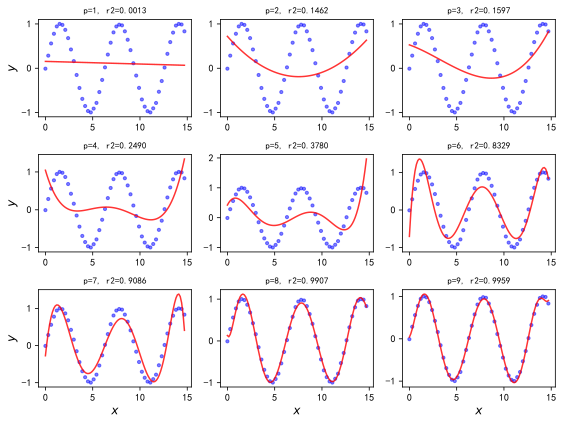

In [70]:
fig = plt.figure(figsize=(8, 6))
for i in range(1, 10):
    p = i
    plm, c_X = polyRegres(X, y, p=p)
    ax = fig.add_subplot(3, 3, i)
    if i >= 7:
        ax.set_xlabel('$x$', size=12)
    if i == 1 or i == 4 or i == 7:
        ax.set_ylabel('$y$', size=12)
        
    ax.set_title(f'p={p}, r2={plm.score(c_X, y):.4f}', size=9)
    ax.scatter(X, y, c='blue', s=10, alpha=0.5)
    x_array = np.linspace(np.min(X), np.max(X), num=100).reshape(-1, 1)
    c_x_array = np.concatenate([x_array**j for j in range(1, p+1)], axis=1)
    ax.plot(x_array, plm.predict(c_x_array), 'r-', lw=1.5, alpha=0.8)
fig.tight_layout()

In [71]:
test_pizza = np.array([[12], [18], [20], [21]])
test_pizza = np.concatenate([test_pizza**i for i in range(1, p+1)], axis=1)
predicted_price = plm.predict(test_pizza)

In [72]:
predicted_price

array([[-5.89359620e-01],
       [ 2.22962265e+02],
       [ 1.72354391e+03],
       [ 3.93639153e+03]])

## 参考资料
1. 周志华. 机器学习. 2019.
2. 邱锡鹏. 神经网络与机器学习. 2020.
3. [阿斯顿·张、李沐、扎卡里 C. 立顿、亚历山大 J. 斯莫拉等. 动手学深度学习. 2020.](https://github.com/d2l-ai/d2l-zh)
4. Christopher M. Bishop. Pattern recognition and machine learning. 2006.

## 附录

[优化方法](./A2.Optimization_methods.ipynb)